In [1]:
# imporrts

from transformers import BertTokenizer, BertModel, AdamW
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from ICD10Encoder import EntityMentionTokenizer, EntityMentionPooling, EntityMentionDataset, ICD10BiEncoder

c:\Users\ihear\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Data

In [2]:
# Load data
import pandas as pd

# annotation data
data = pd.read_csv("Data//split_data.csv")

# full text for context
text_data = pd.read_csv("Data/Final_texts.csv")

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
emt = EntityMentionTokenizer(tokenizer, 128)

In [4]:
def extract_context(text, start_position, end_position, context_size=5):
      # ensure valid positions
        if start_position < 0 or end_position > len(text) or start_position >= end_position:
            raise ValueError("Invalid mention positions")

        # extract mention
        mention = text[start_position:end_position]

        # get the left context and tokenize
        left_context = text[:start_position]
        left_context = left_context.split()[-context_size:]

        # get the right context and tokenize
        right_context = text[end_position:]
        right_context = right_context.split()[:context_size]

        return mention, " ".join(left_context), " ".join(right_context)

In [5]:
# create Mentions Dataframe with a context of 5 tokens each side

mentions_df = pd.DataFrame(columns = ['mention', 'context_left', 'context_right'])

for _, row_texts in text_data.iterrows():
    for _, row_annotations in data.iterrows():
        if row_texts.patient_id == row_annotations.patient_id:
            mention, left_context, right_context = extract_context(row_texts.text, row_annotations.start, row_annotations.end)
            new_df = pd.DataFrame([{'mention': mention, 'context_left': left_context, 'context_right': right_context}])
            mentions_df = pd.concat([mentions_df, new_df], ignore_index=True, axis=0)
        else:
            # move to the next row_texts if patient numbers don't match
            continue

In [6]:
# seperate entitiy-description in a new df
ed_df = data[['code', 'description']]

In [7]:
# split based on 'set' column

train_mentions_df = mentions_df[data['set'] == 'train']
test_mentions_df = mentions_df[data['set'] == 'test']
val_mentions_df = mentions_df[data['set'] == 'validation']

train_ed_df = ed_df[data['set'] == 'train']
test_ed_df = ed_df[data['set'] == 'test']
val_ed_df = ed_df[data['set'] == 'validation']

In [8]:
# tokenize texts

max_length = 128

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
emt = EntityMentionTokenizer(tokenizer, max_length=max_length)

def tokenize_data(df, tokenizer_instance):
    tokenized_data = df.apply(tokenizer_instance, axis=1)
    return list(tokenized_data)

tokenized_mentions_train = tokenize_data(train_mentions_df, emt.tokenizeWcontext)
tokenized_entities_train = tokenize_data(train_ed_df, emt.tokenize_entity_description)

tokenized_mentions_test = tokenize_data(test_mentions_df, emt.tokenizeWcontext)
tokenized_entities_test = tokenize_data(test_ed_df, emt.tokenize_entity_description)

tokenized_mentions_val = tokenize_data(val_mentions_df, emt.tokenizeWcontext)
tokenized_entities_val = tokenize_data(val_ed_df, emt.tokenize_entity_description)

In [9]:
# create special tokens masks

def create_special_tokens_mask(input_ids, tokenizer, special_tokens=["[Ms]", "[Me]"]):
    input_ids = torch.Tensor(input_ids)
    special_token_ids = tokenizer.convert_tokens_to_ids(special_tokens)
    special_tokens_mask = torch.zeros_like(input_ids, dtype=torch.bool)

    for token_id in special_token_ids:
        special_tokens_mask |= (input_ids == token_id)

    return special_tokens_mask

def print_decoded_text(tokenized_input, tokenizer):
    input_ids = tokenized_input['input_ids']
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=False)
    print("Decoded Text:", decoded_text)

# create lists to store special tokens masks and decoded text
train_mention_special_tokens_masks = []
train_entity_special_tokens_masks = []

test_mention_special_tokens_masks = []
test_entity_special_tokens_masks = []

val_mention_special_tokens_masks = []
val_entity_special_tokens_masks = []

# mentions masks
for tokenized_input in tokenized_mentions_train:
    input_ids = tokenized_input['input_ids']
    special_tokens_mask = create_special_tokens_mask(input_ids, emt.tokenizer)
    train_mention_special_tokens_masks.append(special_tokens_mask)

for tokenized_input in tokenized_mentions_test:
    input_ids = tokenized_input['input_ids']
    special_tokens_mask = create_special_tokens_mask(input_ids, emt.tokenizer)
    test_mention_special_tokens_masks.append(special_tokens_mask)

for tokenized_input in tokenized_mentions_val:
    input_ids = tokenized_input['input_ids']
    special_tokens_mask = create_special_tokens_mask(input_ids, emt.tokenizer)
    val_mention_special_tokens_masks.append(special_tokens_mask)


# entities masks
    
for tokenized_input in tokenized_entities_train:
    input_ids = tokenized_input['input_ids']
    special_tokens_mask = create_special_tokens_mask(input_ids, emt.tokenizer, special_tokens=["[ENT]"])
    train_entity_special_tokens_masks.append(special_tokens_mask)

for tokenized_input in tokenized_entities_test:
    input_ids = tokenized_input['input_ids']
    special_tokens_mask = create_special_tokens_mask(input_ids, emt.tokenizer, special_tokens=["[ENT]"])
    test_entity_special_tokens_masks.append(special_tokens_mask)

   
for tokenized_input in tokenized_entities_val:
    input_ids = tokenized_input['input_ids']
    special_tokens_mask = create_special_tokens_mask(input_ids, emt.tokenizer, special_tokens=["[ENT]"])
    val_entity_special_tokens_masks.append(special_tokens_mask)



In [10]:
# create custom datasets
train_dataset = EntityMentionDataset(tokenized_mentions_train, tokenized_entities_train, train_mention_special_tokens_masks, train_entity_special_tokens_masks)
test_dataset = EntityMentionDataset(tokenized_mentions_test, tokenized_entities_test, test_mention_special_tokens_masks, test_entity_special_tokens_masks)
val_dataset = EntityMentionDataset(tokenized_mentions_val, tokenized_entities_val, val_mention_special_tokens_masks, val_entity_special_tokens_masks)

# Train Model

In [11]:
# create dataloaders
batch_size = 8

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
model_mention = BertModel.from_pretrained('bert-base-multilingual-uncased')
model_entity = BertModel.from_pretrained('bert-base-multilingual-uncased')

# Resize token embeddings
model_mention.resize_token_embeddings(len(emt.tokenizer))
model_entity.resize_token_embeddings(len(emt.tokenizer))

# Define separate optimizers for mention and entity transformers
optimizer_mention = AdamW(model_mention.parameters(), lr=1e-5)
optimizer_entity = AdamW(model_entity.parameters(), lr=1e-5)

bi_encoder = ICD10BiEncoder(mention_transformer=model_mention,
                            entity_trasformer=model_entity,
                            optimizer_mention=optimizer_mention,
                            optimizer_entity=optimizer_entity)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.we

In [16]:
mention_pooling = EntityMentionPooling(pool_type="average", special_token_type='mention')
entity_pooling = EntityMentionPooling(pool_type="average", special_token_type='entity')

bi_encoder.train(train_loader, val_loader, num_epochs=5, 
                 checkpoint_folder='NEWTEST2', 
                 mention_pooling=mention_pooling, 
                 entity_pooling=entity_pooling)

[1.0051697492599487, 0.3482528328895569, 0.2601551413536072, 0.23345215618610382, 0.24224770069122314]


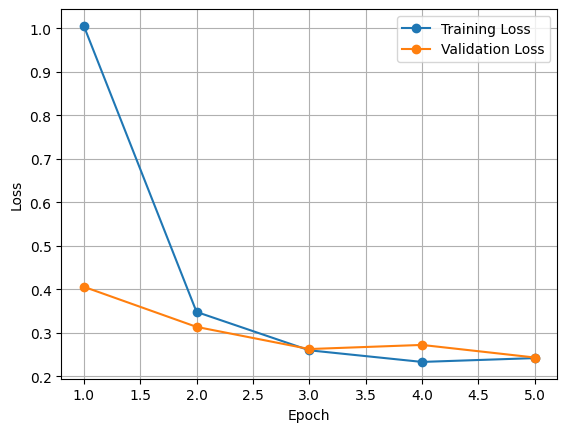

In [20]:
# plot metrics

# train_losses = [1.7504, 0.8169, 0.3866, 0.2901]
train_losses = bi_encoder.train_losses
train_losses = [x.item() for x in train_losses]
print(train_losses)
# val_losses = [1.0710760354995728, 0.6820884943008423, 0.9808986783027649, 0.7468389272689819]
val_losses = bi_encoder.val_losses
val_losses = [x.item() for x in val_losses]
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# get the embeddings of all the test set descriptions 

descr_embeddings = bi_encoder.get_entity_embeddings(test_loader, entity_pooling)